# Download dataset 

In [1]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: 
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination) 

In [2]:
#download_file_from_google_drive('196W2kDoZXRPjzbTjM6uvTidn6aTpsFnS', 'data.json.gz')

In [1]:
import shutil
import gzip
with gzip.open('data.json.gz', 'rb') as f_in:
    with open('data.json', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [2]:
import json 
import pandas as pd 

In [3]:
df = pd.read_json('data.json', lines=True)

In [4]:
def load_data(file_name):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the (head) line
            #if (head is not None) and (count > head):
                #break
    return data

In [5]:
data = load_data('data.json.gz')

In [6]:
df = pd.DataFrame(data)
df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, This is a special book.], [0, It started ...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, A fun, fast paced science fiction thrille...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, Recommended reading to understand what is...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, I really enjoyed this book, and there is ...",4,True,25884323,332732725863131279a8e345b63ac33e


In [7]:
df.shape

(1378033, 7)

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import similarityUserRecommenders as Similarity_user
import SVDRecommender as svdRecommendation
import popular as popularity

In [9]:
users = df['user_id'].unique()
len(users)

18892

In [10]:
books = df['book_id'].unique()
len(books)

25475

# Visualizing dataset 

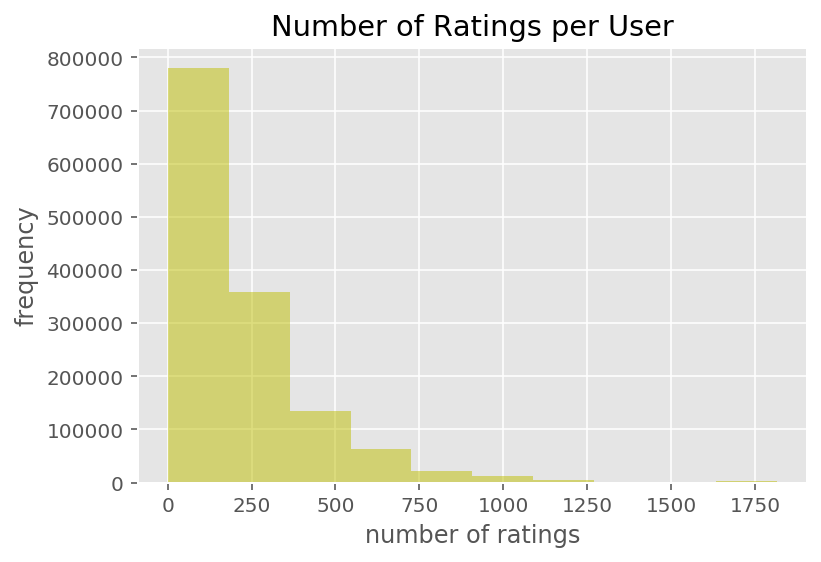

In [11]:
Visualize=pd.DataFrame
Visualize=df.copy()
Visualize['number_of_ratings_user'] = Visualize['user_id'].groupby(Visualize['user_id']).transform('count')
plt.hist(Visualize.number_of_ratings_user, alpha = 0.5, color = 'y')
plt.xlabel('number of ratings')
plt.ylabel('frequency')
plt.title('Number of Ratings per User')
plt.show()

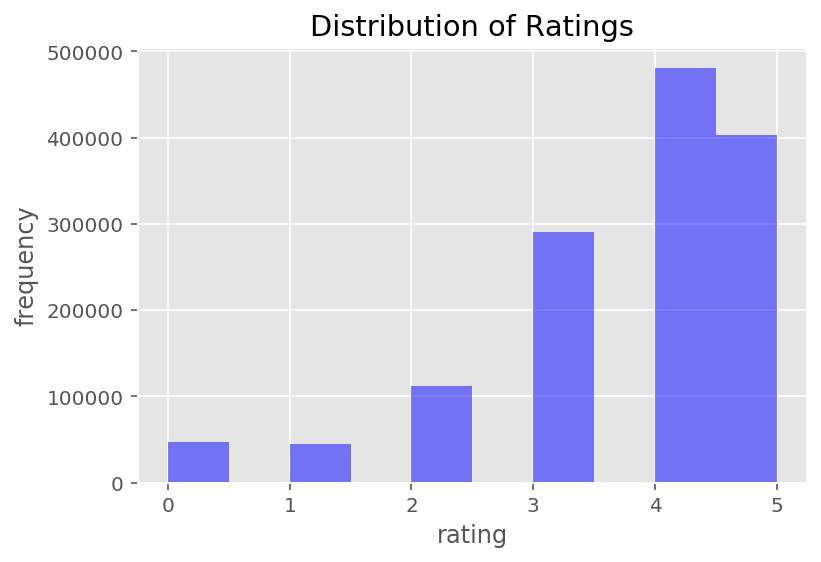

In [12]:
#Distribution of Ratings
plt.hist(Visualize.rating, alpha = 0.5, color='b')
plt.xlabel('rating')
plt.ylabel('frequency')
plt.title('Distribution of Ratings')
plt.show()

In [13]:
Visualize.head(5)

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id,number_of_ratings_user
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, This is a special book.], [0, It started ...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,83
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67,83
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, A fun, fast paced science fiction thrille...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f,83
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, Recommended reading to understand what is...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e,83
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, I really enjoyed this book, and there is ...",4,True,25884323,332732725863131279a8e345b63ac33e,83


## Splitting dataset

In [14]:
train_data, test_data = train_test_split(df, test_size = 0.20, random_state=0)

In [15]:
train_data.head(5)

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
590940,d4d9b2b160a5f06eed2e59395fc0234f,2016-09-14,"[[0, The best in this series so far!], [0, I m...",5,False,28260587,1a3525383abdbc4a4903eb51ad803f93
824811,6a6436200a9267b0b535aec17291eb20,2016-10-22,"[[0, Wow!], [0, What an amazing conclusion to ...",5,False,25944798,d3c81562b50af6b20d63fb9e6ad97948
825044,2b53da327d743ee487f0380358a51f9c,2016-08-18,"[[0, This was my favourite short story in the ...",4,True,17334074,760dff8e05ca657584f3bf966b349ca5
1121513,515621822400ea1ccaaa2727d3536791,2017-03-30,"[[0, I had anticipated that turn but neverthel...",4,False,17790188,a122aca7116a0c838c10f0ee0b3f7df4
149984,ce108cba8d615fef1e00a7005a7d6958,2013-06-24,"[[0, I loved this book, so many action packed ...",5,False,16122643,acca46c1fbae2c63b450ab970f958c1b


# similarity user

In [16]:
Similarity_userModel=Similarity_user.similarityUser()

### create similarity user model

تم أنشاء في الخلية التالبة ديكشناري أفضل بالأداء من مصفوقة المسخدمين والعناصر بحيث يكون شكل###
الديكشناري كالتالي

{user_id1:{book_id1:rating1,book_id2:ratin2},user_id2:{book_id1:rating1,book_idn:ratinn}}

أفضل من أنشاء  مصفوفة من حيث الأداء والحجم والديكشناري لاداعي للغوص بحلقات الفور وغيرها
في حال المصفوفة سيكون الشكل كالتالي

             book_id1 book_id2 .... book_idn
A=[user_id1  rating1   rating2  .... ratingn
   user_id2  rating1   rating2  .... ratingn ]  
   وبالتالي أستهلاك كبير في الداكرة لذلك تم اللجوء لديكشناري
  

In [17]:
user_dictionary=Similarity_userModel.create_dictionary(train_data)

### recommend books for user id

In [18]:
user_id=train_data["user_id"][590940]
user_id

'd4d9b2b160a5f06eed2e59395fc0234f'

In [19]:
#we pass user_id num_suggestion which equals to number of user we need to silmilar with them most similarity
similarity_user,recommended_books=Similarity_userModel.recommend_books(user_id,10)
print(" {similarity_rating  \t  user_id}")
similarity_user

 {similarity_rating  	  user_id}


[(1.0, 'fffe42f796fb60bd03468ac206c321c1'),
 (1.0, 'fffc34d137f5c5c5e1ca1d6f325a4dcf'),
 (1.0, 'fff3d798bbf27d42be50ce445fccbf49'),
 (1.0, 'fff2d524826237f7da79e5ca786c5f48'),
 (1.0, 'fff248be2b38708c2ba7940248f9c5e7'),
 (1.0, 'fff217d58e1f06f8c00226ce4ca1bea0'),
 (1.0, 'ffed06f9c41795ef1d77ba3dd3920b39'),
 (1.0, 'ffe04b83362550282350e035f06d9d79'),
 (1.0, 'ffe007d7696cf95fb6f85bb92bd79739'),
 (1.0, 'ffdc905c54178e607755230066928766')]

In [20]:
print("  {book_id  ,  rating}")
#number 10 means most suggestion books
recommended_books[:10]

  {book_id  ,  rating}


[('29780253', 5.0),
 ('252577', 5.0),
 ('18007564', 5.0),
 ('13539044', 5.0),
 ('5470', 5.0),
 ('5907', 5.0),
 ('10127019', 5.0),
 ('11084145', 5.0),
 ('11480917', 5.0),
 ('8709527', 5.0)]

# popular Recommendation

### most ten popular rating books

In [21]:
Visualize['number_of_ratings_book'] = Visualize['book_id'].groupby(Visualize['book_id']).transform('count') 
popular = Visualize.sort_values('number_of_ratings_book', ascending=False) 
popular = popular.drop_duplicates(subset='book_id', keep="first") 
popular = popular[['book_id', 'number_of_ratings_book']] 
popular.head(10)

,book_id,number_of_ratings_book
707478,11870085,2745
399108,11235712,2289
298375,2767052,2245
1163978,7260188,1990
1163706,29056083,1727
577592,16096824,1724
1165196,11735983,1685
276157,6148028,1675
512590,9460487,1652
772428,16068905,1641


### create most popularity recommendation model 

In [22]:
popularity_model=popularity.popular_py()
filtered_=popularity_model.create(train_data)

C:\Users\PC\popular.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data['number_of_ratings_book_popularity'] = self.train_data['book_id'].groupby(self.train_data['book_id']).transform('count')
C:\Users\PC\popular.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data['average_rating_book'] = self.train_data['rating'].groupby(self.train_data['book_id']).transform('mean')


In [24]:
filtered_.head(5)

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id,number_of_ratings_book_popularity,average_rating_book,score
590940,d4d9b2b160a5f06eed2e59395fc0234f,2016-09-14,"[[0, The best in this series so far!], [0, I m...",5,False,28260587,1a3525383abdbc4a4903eb51ad803f93,590,4.040678,3.866804
87307,88141558d064660f8186759439102e71,2013-12-08,"[[0, CAN WE JUST STOP FOR A SECOND AND TALK AB...",5,False,6936382,d1dff4a4ace2ccb86dcc44df76fd9883,894,4.034676,3.899332
253236,aa66c733fe20fdabca01962533774e81,2017-10-18,"[[0, I am... disappointed.], [0, Before I read...",2,True,29056083,a1b8bcd79a0865eb29fcc5e3687c9ddf,1352,3.180473,3.329523
1245114,5df828dd58783a6e27c3f910865ed191,2015-01-08,"[[0, original review: oh em gee.], [0, ps i ju...",4,False,136251,d3c8c77be8aa21e327941338218f8d46,721,4.621359,4.209810
693581,33cf382a67838b0a6164f6216c3a3e7d,2011-01-22,"[[0, I decided to read The Iron King after rea...",3,False,6644117,2369ce1a3a54948d9d27d16b49b08972,654,3.539755,3.607398


#### recommend books for user id

In [25]:
user_id=train_data["user_id"][590940]

most_popularity=popularity_model.recommend_books(user_id,num_recommendations=10)
most_popularity


popular recommendation
most popular for user_id d4d9b2b160a5f06eed2e59395fc0234f.


,book_id,number_of_ratings_book_popularity,average_rating_book,score
515017,136251,721,4.621359,4.209810
546471,3,879,4.510808,4.187561
125772,23437156,1183,4.404903,4.172113
27337,13206828,1101,4.421435,4.171581
929721,2767052,1768,4.325792,4.170534
1025098,8621462,752,4.513298,4.157834
144934,17927395,924,4.430736,4.147668
551313,11870085,2196,4.247723,4.132522
715897,17167166,962,4.377339,4.121090
87240,13206900,1007,4.305859,4.082661


# singular vector decomisition

### create svd recommendation model

In [26]:
svd_model=svdRecommendation.singular_vector_decompistion()

In [27]:
preds_df=svd_model.create(train_data)

C:\Users\PC\SVDRecommender.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.R = self.pivot.as_matrix()


In [28]:
preds_df.head(5)

book_id,1,10000191,10002296,10006,10016013,10021341,10021420,10024227,10024937,10025007,...,9978124,9985697,9987146,99894,9993763,9995135,9996290,9996331,9998,9999107
0,-0.003714,0.064614,0.027905,-0.007329,-0.025985,0.029346,0.003832,0.026947,0.011449,0.128485,...,0.011979,0.001798,-0.005377,-0.040294,0.000413,0.039654,0.036772,0.043356,-0.014665,0.018806
1,0.035587,-0.010653,0.003445,-0.002224,-0.004577,-0.001064,-0.002944,0.007895,-0.004136,-0.032767,...,-0.008420,0.002698,-0.002740,-0.002561,-0.013797,0.019015,-0.004010,0.002316,-0.004508,0.015088
2,0.035786,-0.001196,-0.001596,0.003043,0.000740,0.000217,0.003143,-0.001419,0.007546,0.002603,...,0.001589,0.001487,0.002602,0.003788,-0.001499,0.007128,0.002273,0.002343,0.002229,-0.005844
3,-0.024091,0.000304,0.001069,0.000902,-0.000849,0.001780,0.000547,0.002418,-0.000674,-0.004110,...,-0.003336,0.002370,0.001273,0.000957,-0.005704,0.000567,0.000915,0.006621,0.000301,0.008079
4,-0.001860,-0.000253,0.000414,0.000309,0.000184,0.000413,0.000032,-0.000010,0.000080,-0.000048,...,-0.000434,0.000268,-0.000072,0.000252,-0.000016,-0.001570,0.000273,0.000201,0.000204,0.001134


In [29]:

user_id=user_id=train_data["user_id"][590940]
print(user_id)
#we will call "get_index_ofUserId_"  function because we use matrix to get index of user_id 
user_id=svd_model.get_index_ofUserId_(user_id)
user_id

d4d9b2b160a5f06eed2e59395fc0234f


0

#### recommend books for user id 

In [36]:
#here we pass user_index becuase we use matrix
already_rated, recommendations = svd_model.recommend_books( user_id, num_recommendations=10)

SVD Recommendation
User 0 has already rated 33 books.
Recommending the highest 10 predicted ratings books not already rated.


#### View books the user has already rated "most ten rating"

In [31]:

already_rated[['book_id',"rating"]].head(10)

,book_id,rating
590940,28260587,5
590961,16096824,5
590965,20572939,5
590957,25944798,5
590959,30226723,5
590964,16429619,5
590944,22840421,5
590937,23475666,5
590951,20764879,5
590962,21569527,5


In [32]:
# View the 10 recommended books for User 487
recommendations

,book_id
86,11735983
396,8306857
695,2767052
767,10025305
160,6148028
3227,256683
595,7171637
3450,9593911
1247,7260188
2262,3777732


In [37]:
# Code to plot precision recall curve
import evaluationModelsAll as Evaluation
import pylab as pl
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


In [43]:
import time
def evaluate_models(test_data,train_data,model_1,model_2,model_type_1,model_type_2):
    
    start = time.time()
    pr = Evaluation.precision_recall_calculator(test_data,train_data, model_1, model_2,model_type_1, model_type_2)
    user_sample = 0.01
    (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)
    end = time.time()
    print(end - start)
    print()
    print("Plotting precision recall curves.")
    plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, model_type_1,
                          ism_avg_precision_list, ism_avg_recall_list, model_type_2)

Length of user_test_and_training:17258
Length of user sample:172

Getting recommendations for user:74803ccd2ad6232b9b4a01f3c31b77fe
user similarity recommendation
most recommendation books for user_id:74803ccd2ad6232b9b4a01f3c31b77fe

popular recommendation
most popular for user_id 74803ccd2ad6232b9b4a01f3c31b77fe.

Getting recommendations for user:d81ef50b6d5ef8fa48e626d7a64f9792
user similarity recommendation
most recommendation books for user_id:d81ef50b6d5ef8fa48e626d7a64f9792

popular recommendation
most popular for user_id d81ef50b6d5ef8fa48e626d7a64f9792.

Getting recommendations for user:72fde3730667c0e733d48fbe93912b80
user similarity recommendation
most recommendation books for user_id:72fde3730667c0e733d48fbe93912b80

popular recommendation
most popular for user_id 72fde3730667c0e733d48fbe93912b80.

Getting recommendations for user:4a38255a998aaae6183c06875d44d8b4
user similarity recommendation
most recommendation books for user_id:4a38255a998aaae6183c06875d44d8b4

popular r

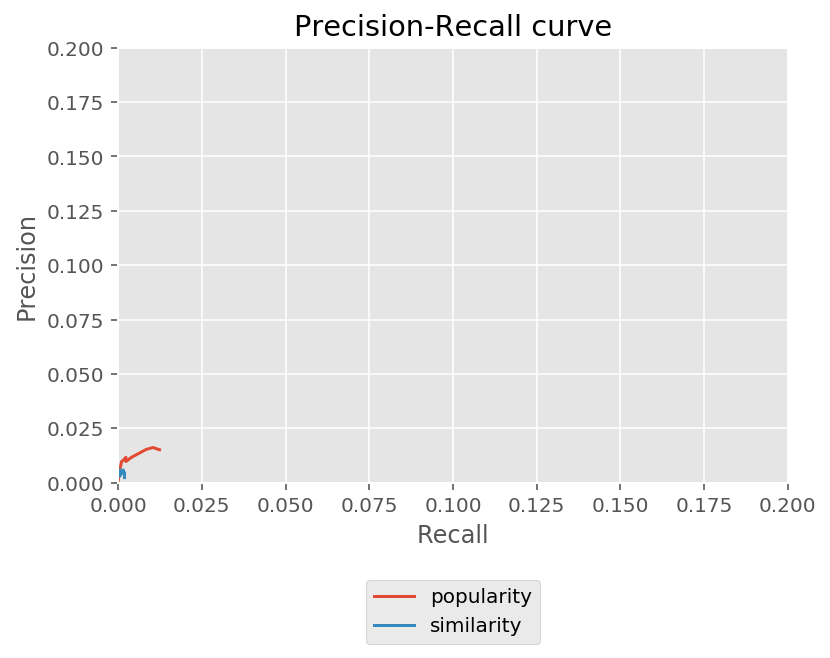

In [44]:
evaluate_models(test_data,train_data,popularity_model,Similarity_userModel,model_type_1="popularity",model_type_2="similarity")

Length of user_test_and_training:17258
Length of user sample:172

Getting recommendations for user:74803ccd2ad6232b9b4a01f3c31b77fe
SVD Recommendation
User 14030 has already rated 153 books.
Recommending the highest 10 predicted ratings books not already rated.

popular recommendation
most popular for user_id 74803ccd2ad6232b9b4a01f3c31b77fe.

Getting recommendations for user:d81ef50b6d5ef8fa48e626d7a64f9792
SVD Recommendation
User 14584 has already rated 127 books.
Recommending the highest 10 predicted ratings books not already rated.

popular recommendation
most popular for user_id d81ef50b6d5ef8fa48e626d7a64f9792.

Getting recommendations for user:72fde3730667c0e733d48fbe93912b80
SVD Recommendation
User 7577 has already rated 330 books.
Recommending the highest 10 predicted ratings books not already rated.

popular recommendation
most popular for user_id 72fde3730667c0e733d48fbe93912b80.

Getting recommendations for user:4a38255a998aaae6183c06875d44d8b4
SVD Recommendation
User 8652 

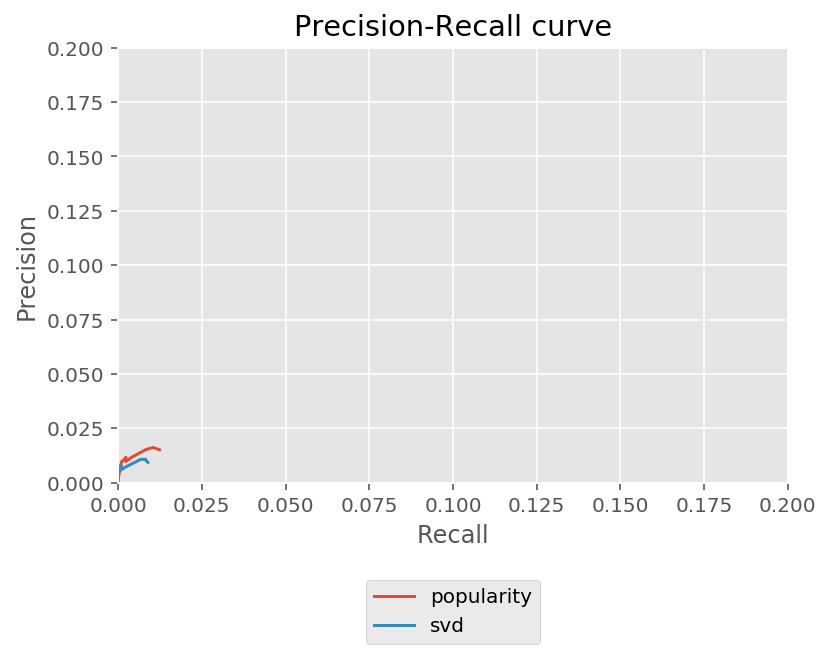

In [45]:
evaluate_models(test_data,train_data,popularity_model,svd_model,model_type_1="popularity",model_type_2="svd")

Length of user_test_and_training:17258
Length of user sample:172

Getting recommendations for user:74803ccd2ad6232b9b4a01f3c31b77fe
user similarity recommendation
most recommendation books for user_id:74803ccd2ad6232b9b4a01f3c31b77fe
SVD Recommendation
User 14030 has already rated 153 books.
Recommending the highest 10 predicted ratings books not already rated.

Getting recommendations for user:d81ef50b6d5ef8fa48e626d7a64f9792
user similarity recommendation
most recommendation books for user_id:d81ef50b6d5ef8fa48e626d7a64f9792
SVD Recommendation
User 14584 has already rated 127 books.
Recommending the highest 10 predicted ratings books not already rated.

Getting recommendations for user:72fde3730667c0e733d48fbe93912b80
user similarity recommendation
most recommendation books for user_id:72fde3730667c0e733d48fbe93912b80
SVD Recommendation
User 7577 has already rated 330 books.
Recommending the highest 10 predicted ratings books not already rated.

Getting recommendations for user:4a382

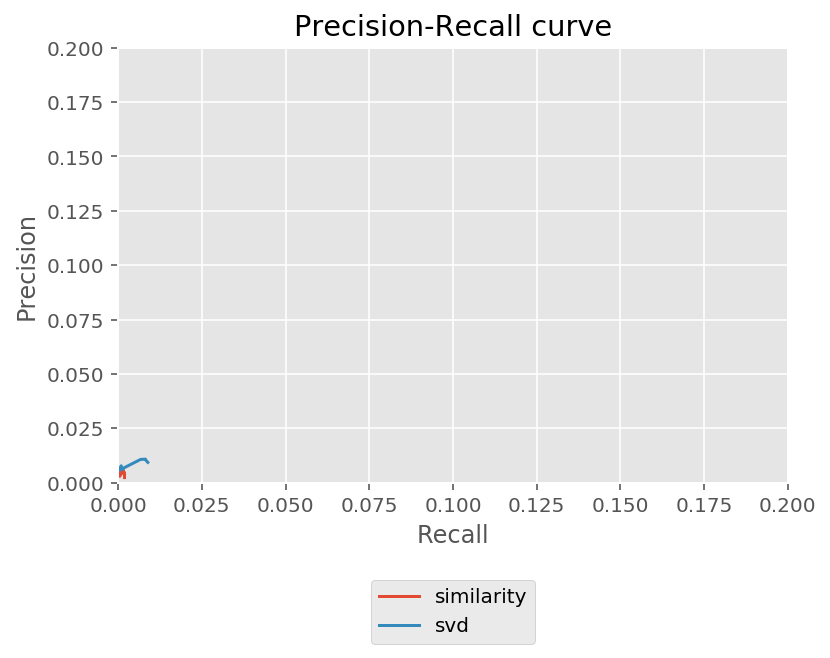

In [46]:
evaluate_models(test_data,train_data,Similarity_userModel,svd_model,model_type_1="similarity",model_type_2="svd")

##
قمنا بعمل تشيك على الملفات الموجودة في الاب رقم 4 حصلنا تقريبا على نفس النتائج الموجودة هنا

